In [1]:
%matplotlib inline
import skimage
import skimage.io as io
import skimage.transform
import sys
import numpy as np
import math
from matplotlib import pyplot
import matplotlib.image as mpimg
print("Required modules imported.")


Required modules imported.


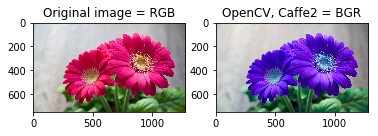

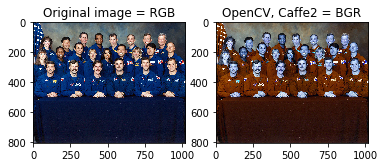

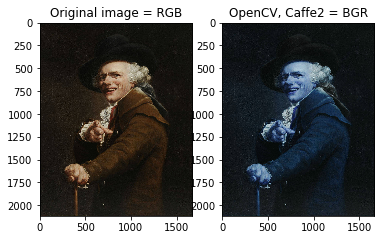

In [6]:
# "https://cdn.pixabay.com/photo/2015/02/10/21/28/flower-631765_1280.jpg",
#                        "https://upload.wikimedia.org/wikipedia/commons/9/9a/Ducreux1.jpg",
for IMAGE_LOCATION in ["flower.jpg",
                       "NASA.jpg",
                       "portrait.jpg"]:

    img = skimage.img_as_float(skimage.io.imread(IMAGE_LOCATION)).astype(np.float32)

    # test color reading
    # show the original image
    pyplot.figure()
    pyplot.subplot(1,2,1)
    pyplot.imshow(img)
    pyplot.axis('on')
    pyplot.title('Original image = RGB')

    # show the image in BGR - just doing RGB->BGR temporarily for display
    imgBGR = img[:, :, (2, 1, 0)]
    #pyplot.figure()
    pyplot.subplot(1,2,2)
    pyplot.imshow(imgBGR)
    pyplot.axis('on')
    pyplot.title('OpenCV, Caffe2 = BGR')

In [3]:
# where you installed caffe2. Probably '~/pytorch' or '~/src/pytorch'.
CAFFE2_ROOT = "~/pytorch"
# assumes being a subdirectory of caffe2
CAFFE_MODELS = "~/pytorch/caffe2/python/models"
# if you have a mean file, place it in the same dir as the model

%matplotlib inline
from caffe2.proto import caffe2_pb2
import numpy as np
import skimage.io
import skimage.transform
from matplotlib import pyplot
import os
from caffe2.python import core, workspace
import urllib
print("Required modules imported.")



Required modules imported.


In [95]:
IMAGE_LOCATION =  "portrait.jpg"

# What model are we using? You should have already converted or downloaded one.
# format below is the model's:
# folder, INIT_NET, predict_net, mean, input image size
# you can switch the comments on MODEL to try out different model conversions
MODEL = 'squeezenet', 'init_net.pb', 'predict_net.pb', 'ilsvrc_2012_mean.npy', 227

# codes - these help decypher the output and source from a list from AlexNet's object codes to provide an result like "tabby cat" or "lemon" depending on what's in the picture you submit to the neural network.
# The list of output codes for the AlexNet models (also squeezenet)
codes =  "https://gist.githubusercontent.com/aaronmarkham/cd3a6b6ac071eca6f7b4a6e40e6038aa/raw/9edb4038a37da6b5a44c3b5bc52e448ff09bfe5b/alexnet_codes"
print("Config set!")

Config set!


Functions set.
mean was set to:  128
Houston, you may have a problem.
INIT_NET =  /home/enigmaeth/pytorch/caffe2/python/models/squeezenet/init_net.pb
PREDICT_NET =  /home/enigmaeth/pytorch/caffe2/python/models/squeezenet/predict_net.pb
/home/enigmaeth/pytorch/caffe2/python/models/squeezenet/init_net.pb not found!
Original image shape:(2116, 1667, 3) and remember it should be in H, W, C!
Orginal aspect ratio: 0.7878071833648393


/home/enigmaeth/miniconda3/envs/caffe2/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/enigmaeth/miniconda3/envs/caffe2/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


New image shape:(288, 227, 3) in HWC
After crop:  (227, 227, 3)
NCHW:  (1, 3, 227, 227)


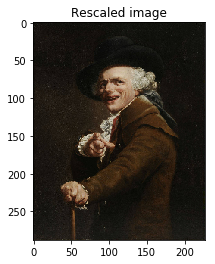

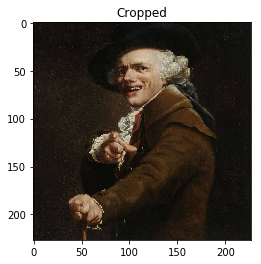

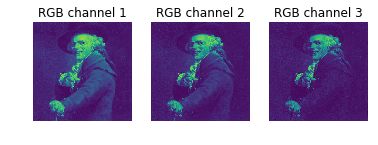

In [96]:
import os
def crop_center(img,cropx,cropy):
    y,x,c = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

def rescale(img, input_height, input_width):
    print("Original image shape:" + str(img.shape) + " and remember it should be in H, W, C!")
#     print("Model's input shape is %dx%d") % (input_height, input_width)
    aspect = img.shape[1]/float(img.shape[0])
    print("Orginal aspect ratio: " + str(aspect))
    if(aspect>1):
        # landscape orientation - wide image
        res = int(aspect * input_height)
        imgScaled = skimage.transform.resize(img, (input_width, res))
    if(aspect<1):
        # portrait orientation - tall image
        res = int(input_width/aspect)
        imgScaled = skimage.transform.resize(img, (res, input_height))
    if(aspect == 1):
        imgScaled = skimage.transform.resize(img, (input_width, input_height))
    pyplot.figure()
    pyplot.imshow(imgScaled)
    pyplot.axis('on')
    pyplot.title('Rescaled image')
    print("New image shape:" + str(imgScaled.shape) + " in HWC")
    return imgScaled
print("Functions set.")

# set paths and variables from model choice and prep image
CAFFE2_ROOT = os.path.expanduser(CAFFE2_ROOT)
CAFFE_MODELS = os.path.expanduser(CAFFE_MODELS)

# mean can be 128 or custom based on the model
# gives better results to remove the colors found in all of the training images
MEAN_FILE = os.path.join(CAFFE_MODELS, MODEL[0], MODEL[3])
if not os.path.exists(MEAN_FILE):
    mean = 128
else:
    mean = np.load(MEAN_FILE).mean(1).mean(1)
    mean = mean[:, np.newaxis, np.newaxis]
print("mean was set to: ", mean)

# some models were trained with different image sizes, this helps you calibrate your image
INPUT_IMAGE_SIZE = MODEL[4]

# make sure all of the files are around...
if not os.path.exists(CAFFE2_ROOT):
    print("Houston, you may have a problem.")
INIT_NET = os.path.join(CAFFE_MODELS, MODEL[0], MODEL[1])
print('INIT_NET = ', INIT_NET)
PREDICT_NET = os.path.join(CAFFE_MODELS, MODEL[0], MODEL[2])
print('PREDICT_NET = ', PREDICT_NET)
if not os.path.exists(INIT_NET):
    print(INIT_NET + " not found!")
else:
    print("Found ", INIT_NET, "...Now looking for", PREDICT_NET)
    if not os.path.exists(PREDICT_NET):
        print("Caffe model file, " + PREDICT_NET + " was not found!")
    else:
        print("All needed files found! Loading the model in the next block.")

# load and transform image
img = skimage.img_as_float(skimage.io.imread(IMAGE_LOCATION)).astype(np.float32)
img = rescale(img, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)
img = crop_center(img, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)
print("After crop: " , img.shape)
pyplot.figure()
pyplot.imshow(img)
pyplot.axis('on')
pyplot.title('Cropped')

# switch to CHW
img = img.swapaxes(1, 2).swapaxes(0, 1)
pyplot.figure()
for i in range(3):
    # For some reason, pyplot subplot follows Matlab's indexing
    # convention (starting with 1). Well, we'll just follow it...
    pyplot.subplot(1, 3, i+1)
    pyplot.imshow(img[i])
    pyplot.axis('off')
    pyplot.title('RGB channel %d' % (i+1))

# switch to BGR
img = img[(2, 1, 0), :, :]

# remove mean for better results
img = img * 255 - mean

# add batch size
img = img[np.newaxis, :, :, :].astype(np.float32)
print("NCHW: ", img.shape)

In [97]:
# initialize the neural net

INIT_NET = 'init_net.pb'
PREDICT_NET = 'predict_net.pb'
with open(INIT_NET, 'rb') as f:
    init_net = f.read()
with open(PREDICT_NET, 'rb') as f:
    predict_net = f.read()

p = workspace.Predictor(init_net, predict_net)

# run the net and return prediction
results = p.run({'data': img})

# turn it into something we can play with and examine which is in a multi-dimensional array
results = np.asarray(results)
print ("results shape: ", results.shape)


results shape:  (1, 1, 1000, 1, 1)


In [98]:
# the rest of this is digging through the results

results = np.delete(results, 1)
index = 0
highest = 0
arr = np.empty((0,2), dtype=object)
arr[:,0] = int(10)
arr[:,1:] = float(10)
for i, r in enumerate(results):
    # imagenet index begins with 1!
    i=i+1
    arr = np.append(arr, np.array([[i,r]]), axis=0)
    if (r > highest):
        highest = r
        index = i

print (index, " :: ", highest)

# lookup the code and return the result
# top 3 results
# sorted(arr, key=lambda x: x[1], reverse=True)[:3


568  ::  0.10253129
